In [ ]:
!pip install pyngrok
import os, io, json, warnings, joblib,uvicorn
warnings.filterwarnings("ignore")
import pandas as pd, numpy as np
from datetime import datetime
from pyngrok import ngrok
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.arima.model import ARIMA
from fastapi import FastAPI
from fastapi.responses import HTMLResponse
from pydantic import BaseModel
import shap
import nest_asyncio
import asyncio
import matplotlib.pyplot as plt

from google.colab import files
uploaded = files.upload()

from sklearn.model_selection import train_test_split
import tensorflow as tf
warnings.filterwarnings("ignore")

Saving covid-19outbreaksbymonth_03jun25 (1).csv to covid-19outbreaksbymonth_03jun25 (1) (2).csv


In [ ]:
for filename in uploaded.keys():
    df = pd.read_csv(filename)
    print("Loaded:", filename)

df.head()

Loaded: covid-19outbreaksbymonth_03jun25 (1).csv


,MonthYear,IndustrySector,IndividualSetting,IndCode,Outbreaks,Cases
0,Before Jan 2021,Accommodation and Food Services,"Recreational vehicle parks and camps, and room...",8670,2,2
1,Before Jan 2021,Accommodation and Food Services,Restaurants and other food services,8680,275,1849
2,Before Jan 2021,Accommodation and Food Services,Traveler accommodation,8660,36,298
3,Before Jan 2021,Administrative and support and waste managemen...,Business support services,7590,4,30
4,Before Jan 2021,Administrative and support and waste managemen...,Employment services,7580,5,24


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

print("SHAPE:", df.shape)
print("\nINFO:")
print(df.info())
print("\nMISSING VALUES:")
print(df.isnull().sum())
print("\nDESCRIPTIVE STATISTICS:")
print(df.describe())

SHAPE: (3834, 7)

INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3834 entries, 0 to 3833
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   MonthYear          3834 non-null   object        
 1   IndustrySector     3833 non-null   object        
 2   IndividualSetting  3833 non-null   object        
 3   IndCode            3834 non-null   int64         
 4   Outbreaks          3834 non-null   int64         
 5   Cases              3834 non-null   int64         
 6   Date               3834 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 209.8+ KB
None

MISSING VALUES:
MonthYear            0
IndustrySector       1
IndividualSetting    1
IndCode              0
Outbreaks            0
Cases                0
Date                 0
dtype: int64

DESCRIPTIVE STATISTICS:
           IndCode    Outbreaks         Cases                           Date
count 

In [ ]:
def convert_monthyear(val):
    val = str(val).strip()

    # date format
    try:
        return pd.to_datetime(val, format="%b-%y")
    except:
        pass

    # change "Before Jan 2021"
    if "Before" in val:
        month = val.replace("Before", "").strip()   # "Jan 2021"
        parsed = pd.to_datetime(month, format="%b %Y")
        return parsed - pd.DateOffset(months=1)

    # Fallback
    return pd.NaT


df["Date"] = df["MonthYear"].apply(convert_monthyear)

# Drop rows
df = df.dropna(subset=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

df[["MonthYear", "Date"]].head(10)

,MonthYear,Date
0,Before Jan 2021,2020-12-01
1,Before Jan 2021,2020-12-01
2,Before Jan 2021,2020-12-01
3,Before Jan 2021,2020-12-01
4,Before Jan 2021,2020-12-01
5,Before Jan 2021,2020-12-01
6,Before Jan 2021,2020-12-01
7,Before Jan 2021,2020-12-01
8,Before Jan 2021,2020-12-01
9,Before Jan 2021,2020-12-01


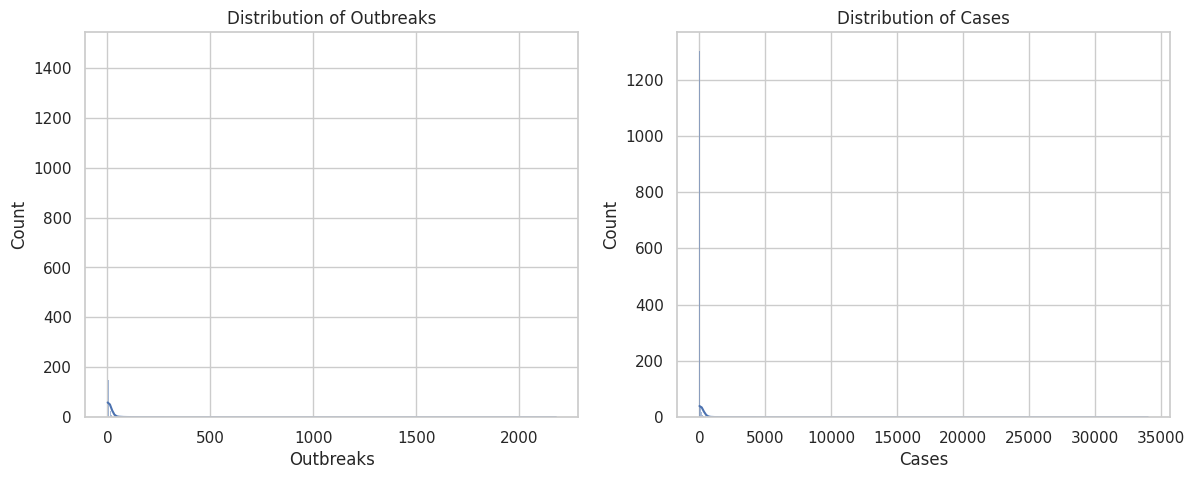

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,5))

sns.histplot(df["Outbreaks"], kde=True, ax=ax[0])
ax[0].set_title("Distribution of Outbreaks")

sns.histplot(df["Cases"], kde=True, ax=ax[1])
ax[1].set_title("Distribution of Cases")

plt.show()


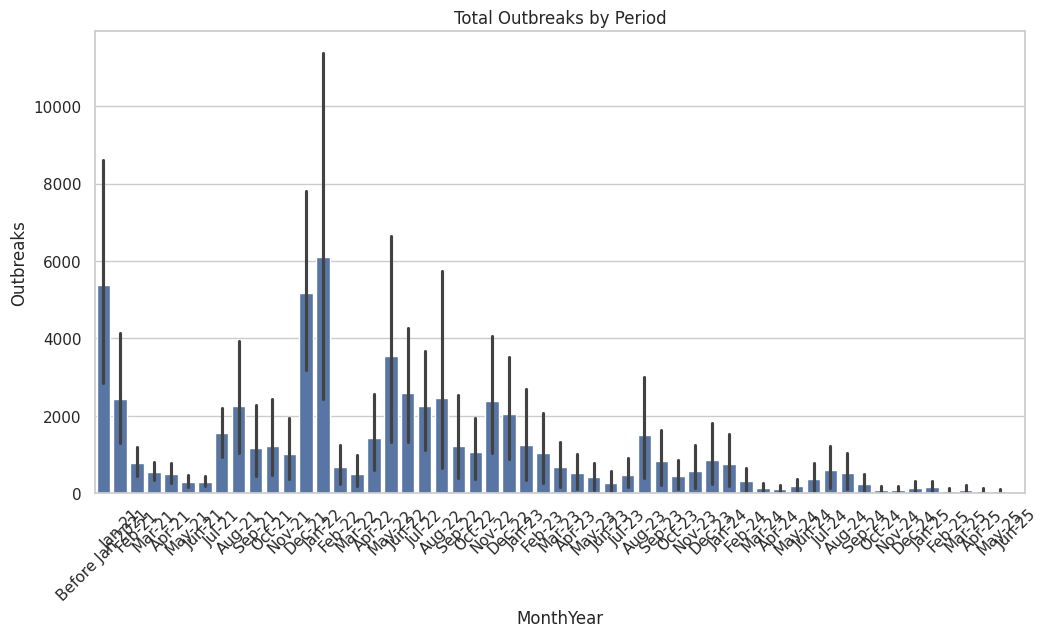

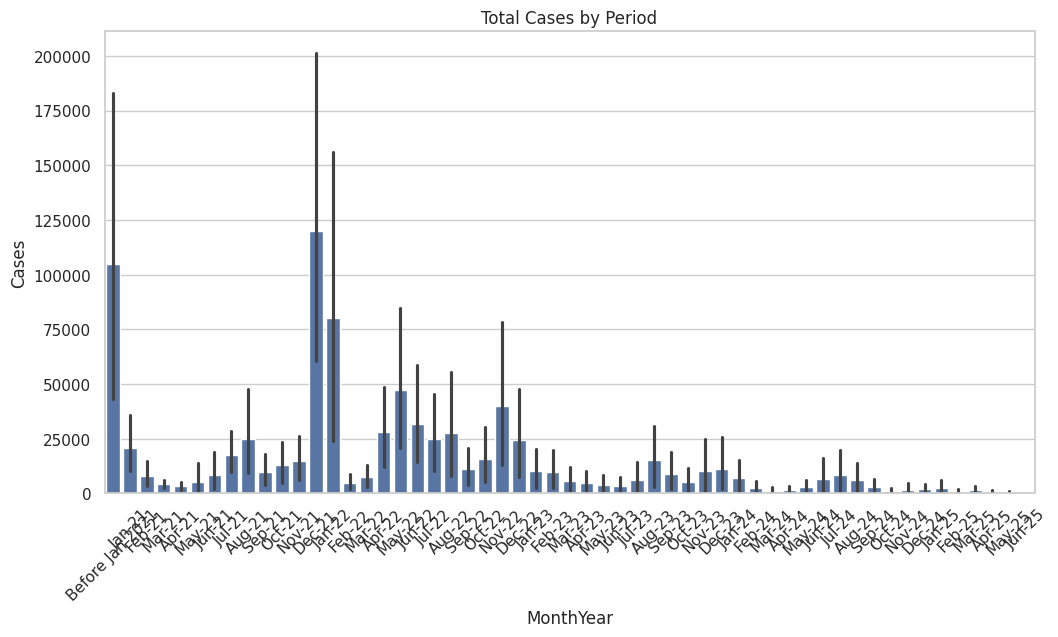

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=df, x="MonthYear", y="Outbreaks", estimator=sum)
plt.title("Total Outbreaks by Period")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12,6))
sns.barplot(data=df, x="MonthYear", y="Cases", estimator=sum)
plt.title("Total Cases by Period")
plt.xticks(rotation=45)
plt.show()


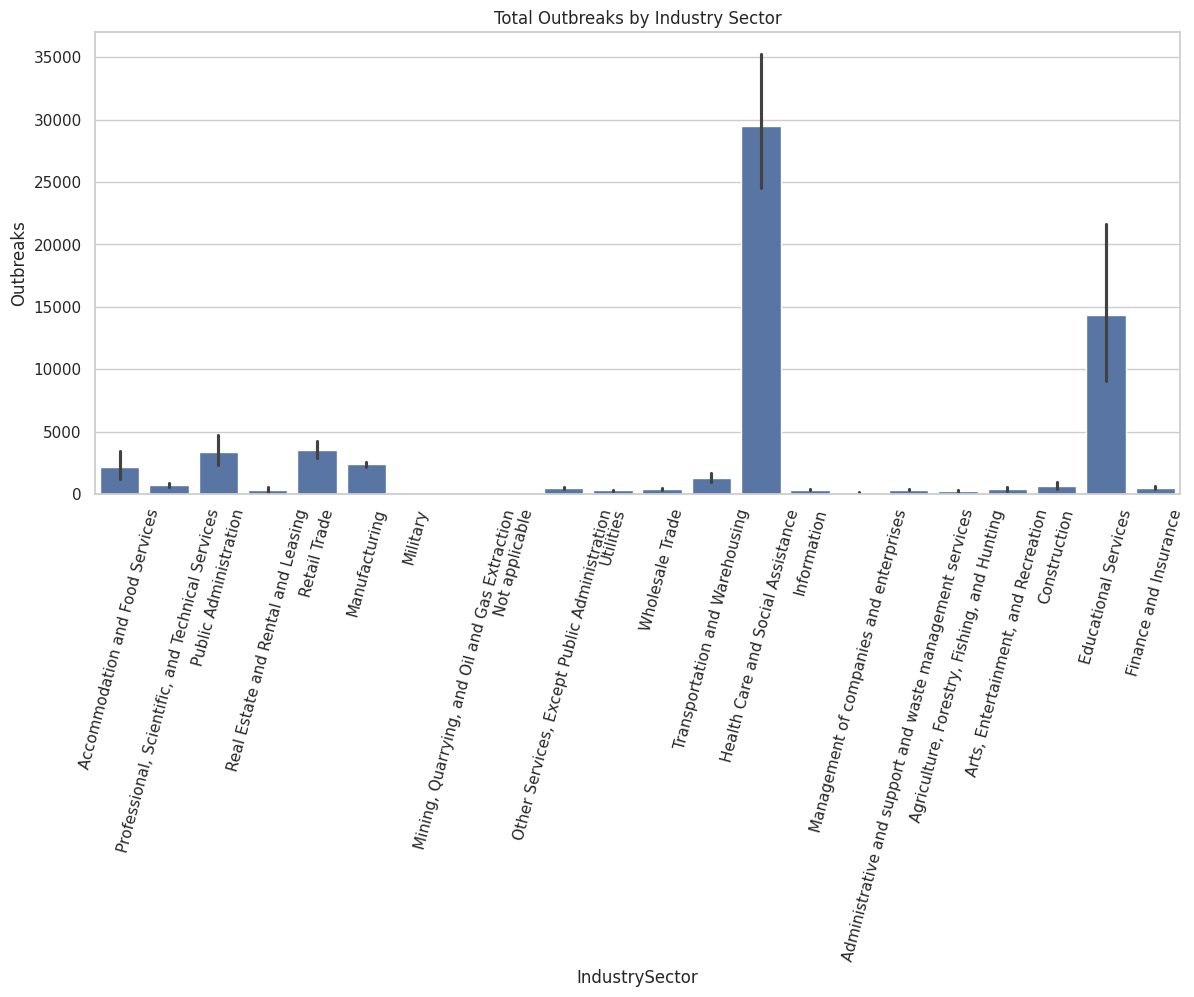

In [ ]:
plt.figure(figsize=(14,6))
sns.barplot(data=df, x="IndustrySector", y="Outbreaks", estimator=sum)
plt.title("Total Outbreaks by Industry Sector")
plt.xticks(rotation=75)
plt.show()


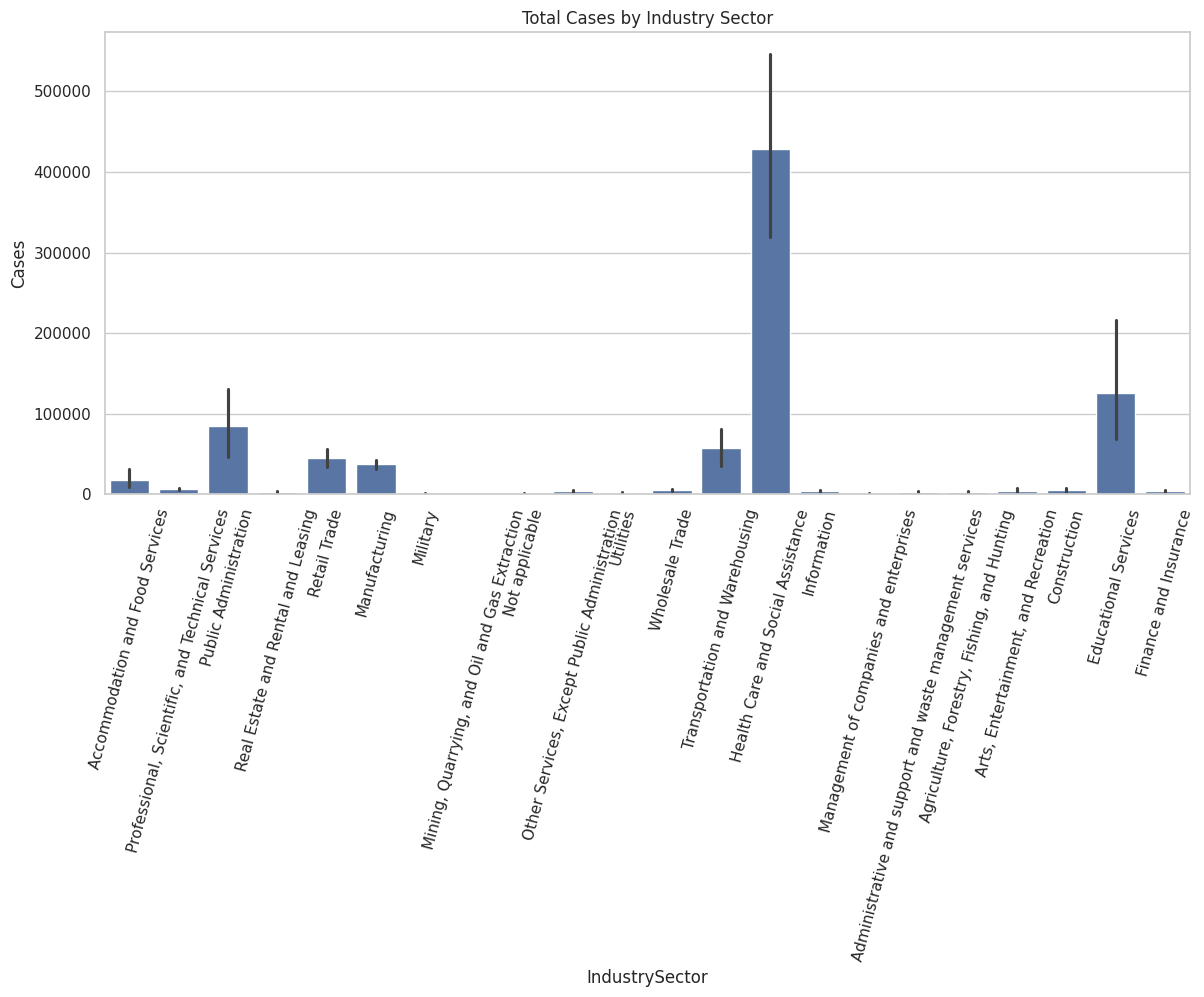

In [ ]:
plt.figure(figsize=(14,6))
sns.barplot(data=df, x="IndustrySector", y="Cases", estimator=sum)
plt.title("Total Cases by Industry Sector")
plt.xticks(rotation=75)
plt.show()


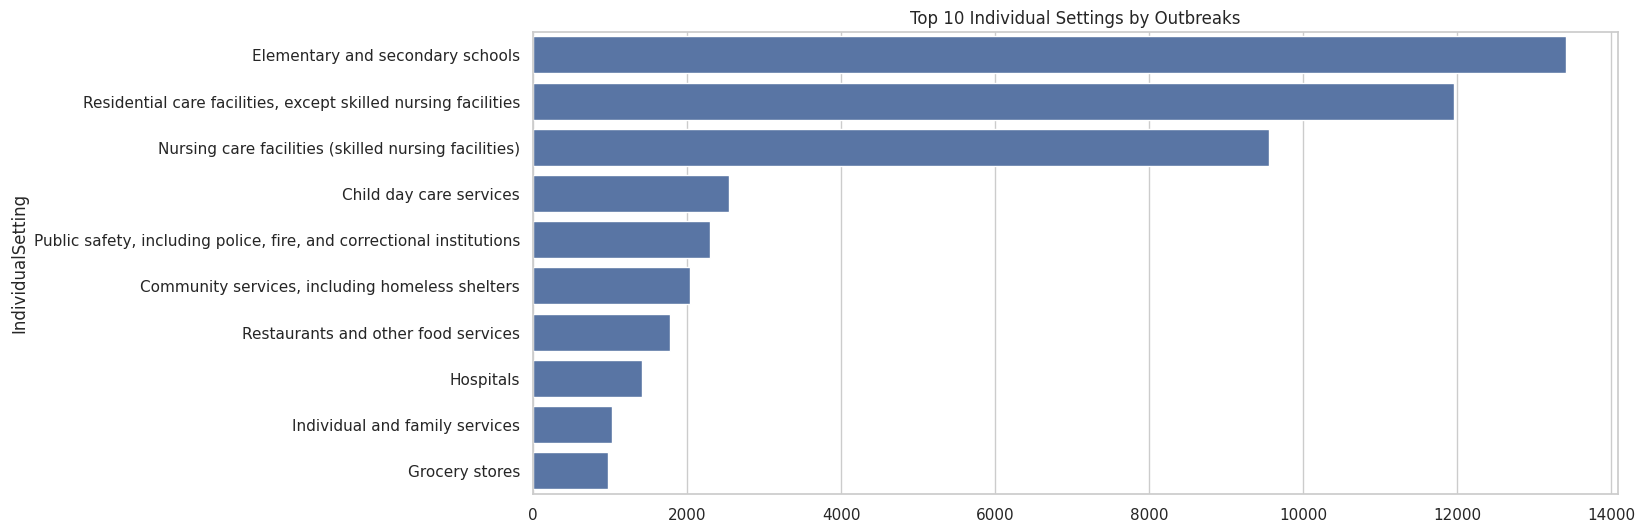

In [ ]:
top_settings = df.groupby("IndividualSetting")["Outbreaks"].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(14,6))
sns.barplot(x=top_settings.values, y=top_settings.index)
plt.title("Top 10 Individual Settings by Outbreaks")
plt.show()


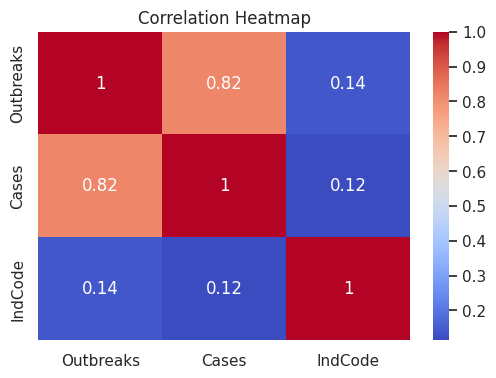

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(df[["Outbreaks", "Cases", "IndCode"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


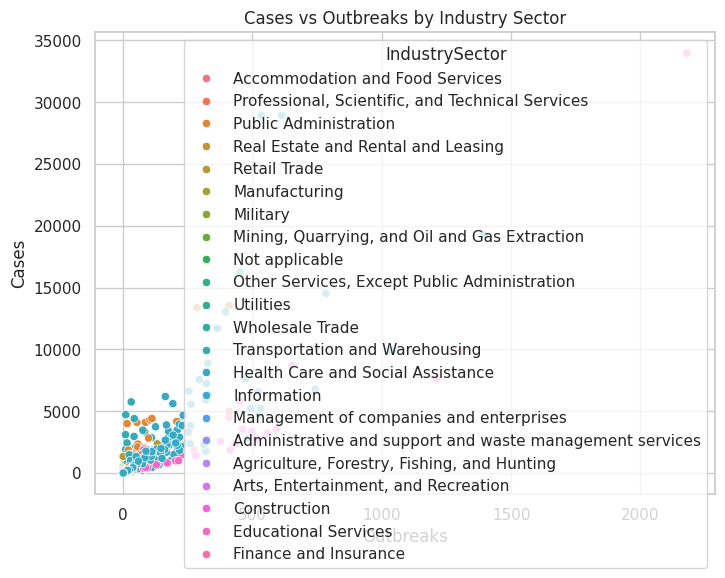

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x="Outbreaks", y="Cases", hue="IndustrySector")
plt.title("Cases vs Outbreaks by Industry Sector")
plt.show()


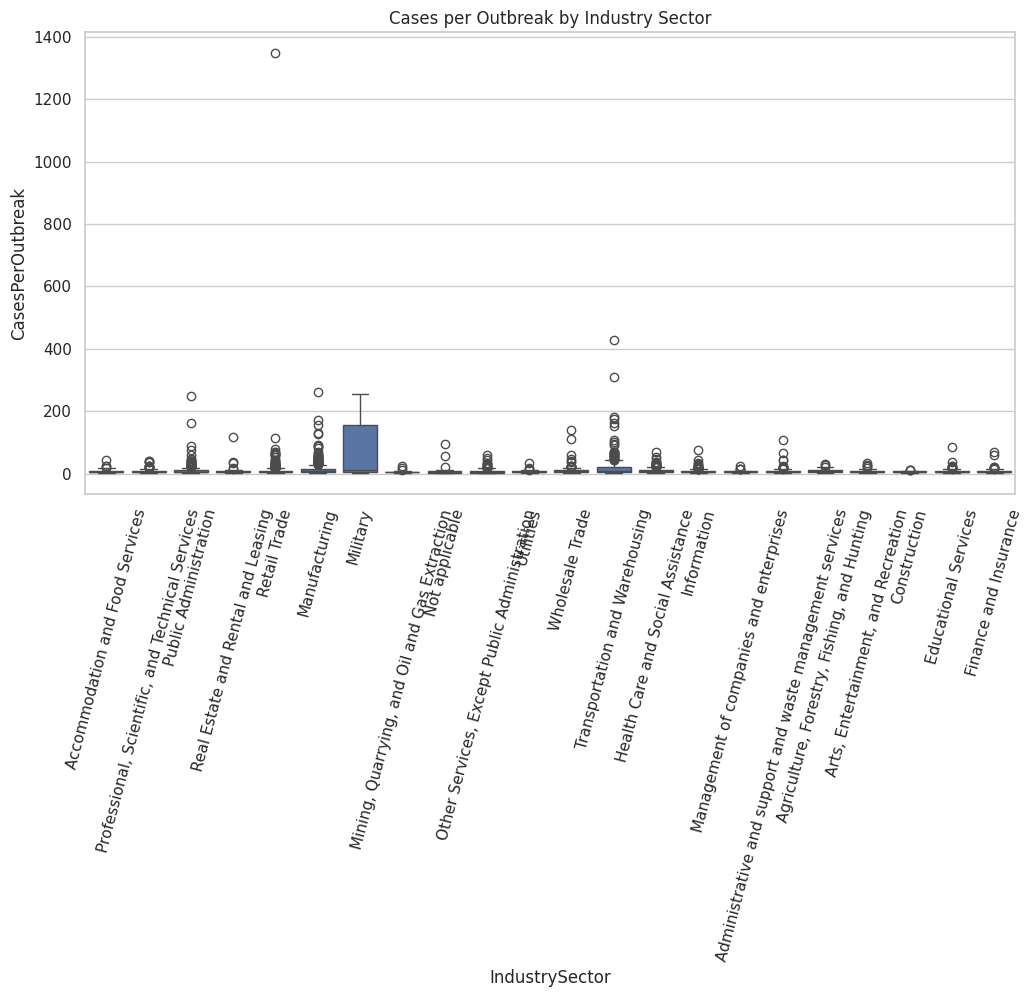

In [ ]:
df["CasesPerOutbreak"] = df["Cases"] / df["Outbreaks"]

plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="IndustrySector", y="CasesPerOutbreak")
plt.title("Cases per Outbreak by Industry Sector")
plt.xticks(rotation=75)
plt.show()


In [ ]:
outbreak_summary = df.groupby("IndustrySector")[["Outbreaks","Cases"]].sum().sort_values("Outbreaks", ascending=False)
print(outbreak_summary)


                                                    Outbreaks   Cases
IndustrySector                                                       
Health Care and Social Assistance                       29491  428571
Educational Services                                    14374  125604
Retail Trade                                             3566   44607
Public Administration                                    3368   84598
Manufacturing                                            2425   37180
Accommodation and Food Services                          2165   18243
Transportation and Warehousing                           1319   57264
Professional, Scientific, and Technical Services          731    6203
Construction                                              651    4972
Finance and Insurance                                     528    3945
Other Services, Except Public Administration              516    4324
Wholesale Trade                                           449    4877
Arts, Entertainment,

In [ ]:
print(df.groupby("MonthYear")[["Outbreaks","Cases"]].sum())


                 Outbreaks   Cases
MonthYear                         
Apr-21                 495    3148
Apr-22                1437   27855
Apr-23                 527    4803
Apr-24                 107    1569
Apr-25                  71     811
Aug-21                2251   24679
Aug-22                2456   27486
Aug-23                1510   15142
Aug-24                 529    6258
Before Jan 2021       5375  104794
Dec-21                5174  119739
Dec-22                2054   24582
Dec-23                 870   11227
Dec-24                 136    1836
Feb-21                 777    7724
Feb-22                 678    4881
Feb-23                1031    9667
Feb-24                 320    2635
Feb-25                  68     841
Jan-21                2438   20803
Jan-22                6101   80306
Jan-23                1258   10115
Jan-24                 756    7068
Jan-25                 152    2498
Jul-21                1550   17520
Jul-22                2264   25016
Jul-23              

In [ ]:
target = "Cases"
y = df[target]


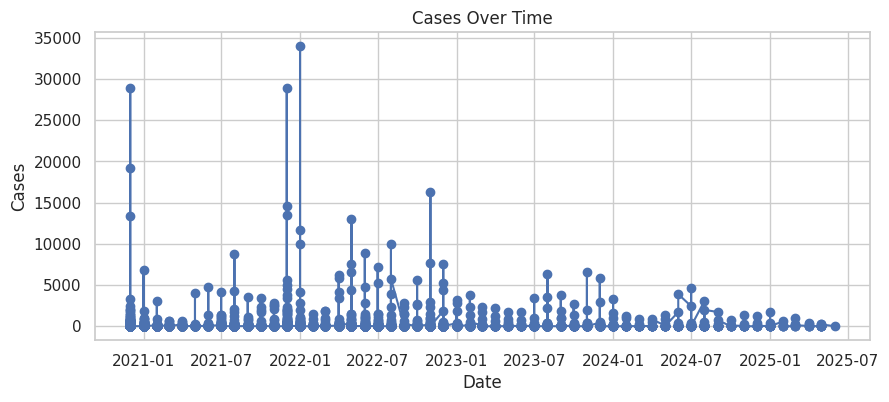

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df["Date"], y, marker="o")
plt.title(f"{target} Over Time")
plt.xlabel("Date")
plt.ylabel(target)
plt.grid(True)
plt.show()


In [ ]:
series = y.values

train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

arima = ARIMA(train, order=(2,1,2))
fit = arima.fit()

forecast_arima = fit.forecast(steps=len(test))

print("ARIMA Results:")
print("MAE:", mean_absolute_error(test, forecast_arima))
print("RMSE:", np.sqrt(mean_squared_error(test, forecast_arima)))
print("R²:", r2_score(test, forecast_arima))


ARIMA Results:
MAE: 270.3441037951503
RMSE: 636.3732916162008
R²: 0.0022291852511262533


In [ ]:
encode_cols = ["IndustrySector", "IndividualSetting", "IndCode"]

df_encoded = df.copy()
for col in encode_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

df_encoded["DateIndex"] = pd.factorize(df_encoded["Date"])[0]

X = df_encoded[encode_cols + ["DateIndex"]]
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

rf = RandomForestRegressor(n_estimators=200)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)

print("Random Forest Results:")
print("MAE:", mean_absolute_error(y_test, pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_rf)))
print("R²:", r2_score(y_test, pred_rf))


Random Forest Results:
MAE: 370.6560625814863
RMSE: 937.3478283627912
R²: -1.1647535637381514


In [ ]:
def create_sequences(values, steps=3):
    X, y = [], []
    for i in range(len(values) - steps):
        X.append(values[i:i+steps])
        y.append(values[i+steps])
    return np.array(X), np.array(y)

values = df[target].values
steps = 3

X_seq, y_seq = create_sequences(values, steps)

train_size = int(len(X_seq) * 0.8)

X_train = X_seq[:train_size].reshape(-1, steps, 1)
X_test  = X_seq[train_size:].reshape(-1, steps, 1)
y_train = y_seq[:train_size]
y_test  = y_seq[train_size:]

model = Sequential([
    LSTM(32, activation="relu", input_shape=(steps, 1)),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.fit(X_train, y_train, epochs=30, batch_size=8, verbose=0)

pred_lstm = model.predict(X_test).flatten()

print("LSTM Results:")
print("MAE:", mean_absolute_error(y_test, pred_lstm))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred_lstm)))
print("R²:", r2_score(y_test, pred_lstm))


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
LSTM Results:
MAE: 181.81907653808594
RMSE: 654.3783070594562
R²: -0.05502974987030029


In [ ]:
results = pd.DataFrame({
    "Model": ["ARIMA", "Random Forest", "LSTM"],
    "MAE": [
        mean_absolute_error(test, forecast_arima),
        mean_absolute_error(y_test, pred_rf),
        mean_absolute_error(y_test, pred_lstm)
    ],
    "RMSE": [
        np.sqrt(mean_squared_error(test, forecast_arima)),
        np.sqrt(mean_squared_error(y_test, pred_rf)),
        np.sqrt(mean_squared_error(y_test, pred_lstm))
    ],
    "R²": [
        r2_score(test, forecast_arima),
        r2_score(y_test, pred_rf),
        r2_score(y_test, pred_lstm)
    ]
})

results


,Model,MAE,RMSE,R²
0,ARIMA,270.344104,636.373292,0.002229
1,Random Forest,370.656063,937.347828,-1.164754
2,LSTM,181.819077,654.378307,-0.055030
